In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import io
from matplotlib.animation import FuncAnimation
from matplotlib.animation import ArtistAnimation
from PIL import Image
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import ImageGrid
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d as histo2D

In [45]:
path = 'data/filtered2013.csv'

dtypes = {'gps_site': str,
 'sat_id': str,
 'gdlatr': float,
 'gdlonr': float,
 'los_tec': float,
 'tec': float,
 'azm': float,
 'elm': float,
 'gdlat': float,
 'glon': float,
 'gnss_type': str,
 'slant_f': float,
 'vtec': float,
 'pair_id': str,
 'curve_id': int,
 'filtered': float,
 'blrmvd': float}

raw = pd.read_csv(path, dtype=dtypes)

raw['datetime'] = pd.to_datetime(raw['datetime'])

## Delete the first and last 15 mins of each curve + elevation filter + filter out night time data

In [46]:
MIN_ELEVATION = 20

def trim_curve(group):
    group = group.sort_values('datetime')
    start_time = group['datetime'].iloc[0] + timedelta(minutes=15)
    end_time = group['datetime'].iloc[-1] - timedelta(minutes=15)
    return group[(group['datetime'] >= start_time) & (group['datetime'] <= end_time)]

data = raw.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)
data = data.loc[data['elm'] > MIN_ELEVATION]
data = data[(data['datetime'].dt.hour >= 6) & (data['datetime'].dt.hour < 18)]

C:\Users\virtanem\AppData\Local\Temp\ipykernel_8540\460248443.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = raw.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)


## Filter out frames with less than 1000 datapoints

In [ ]:
df = data.groupby('datetime').filter(lambda x: len(x) >= 1000)
print(len(df['datetime'].unique()), len(data['datetime'].unique()))
frames = sorted(df['datetime'].unique())

df0 = data.groupby('datetime').filter(lambda x: len(x) <= 400)
print(len(df0['datetime'].unique()), len(data['datetime'].unique()))
blips = sorted(df0['datetime'].unique())
blip_sites = df0['gps_site'].unique().tolist()
print(blip_sites)

## Creating the animation

### pierce points

MovieWriter ffmpeg unavailable; using Pillow instead.


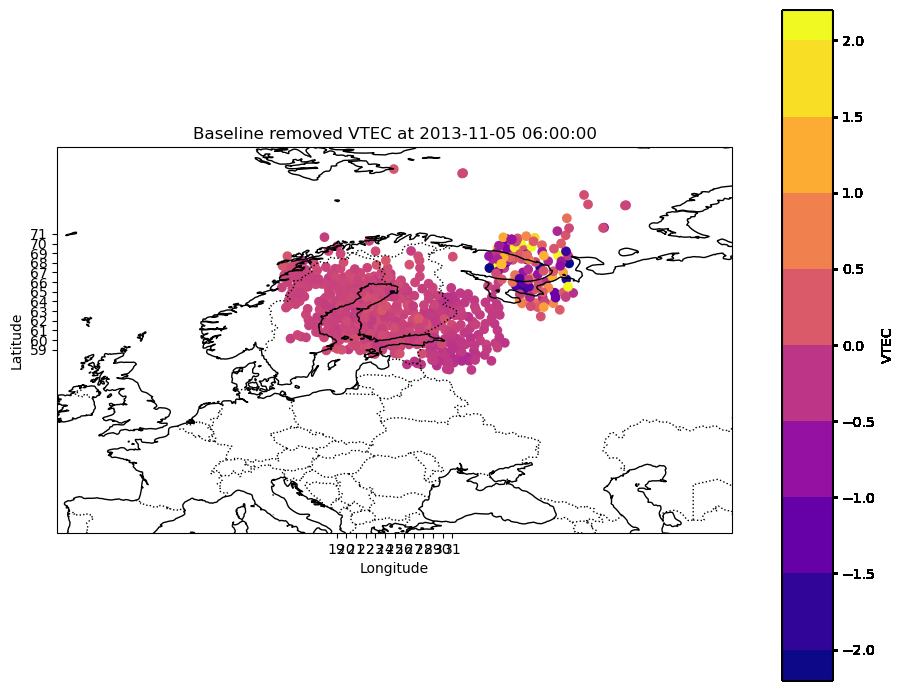

In [57]:
def pp(frame):
    df1 = data.loc[data['datetime'] == frame]

    ax.clear()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.set_xticks(np.arange(19, 32, 1))
    ax.set_yticks(np.arange(59, 72, 1))

    contour = ax.scatter(df1['glon'], df1['gdlat'],c= df1['blrmvd'], cmap='plasma', vmin=-2, vmax=2)

    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                        extendrect = True, label='VTEC',
                        ticks=np.arange(-2,2.5,0.5),
                        boundaries = np.arange(-2,2.5,0.5), 
                        extend='both'
    )

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed VTEC at {frame}')

    ax.set_xlim(-10, 60)
    ax.set_ylim(40, 80)

frames = sorted(data['datetime'].unique())

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

animation = FuncAnimation(fig, pp, frames=frames[:80], interval=30)

animation.save('pp3_animation.gif')

### 2D histogram

In [ ]:
def histo(frame):
    df1 = df.loc[df['datetime'] == frame]

    statistic, x_edges, y_edges, _ = histo2D(
        df1['glon'], df1['gdlat'], df1['blrmvd'], statistic='mean', 
        bins=[np.arange(19, 32 + RES, RES), np.arange(59, 72 + RES, RES)]
    )

    X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2)

    ax.clear()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.set_xticks(np.arange(19, 32, 1))
    ax.set_yticks(np.arange(59, 72, 1))

    contour = ax.contourf(X, Y, statistic.T, cmap='plasma', vmin=-2, vmax=2, 
                          levels=np.linspace(-2, 2, 9), extend='both', transform=ccrs.PlateCarree())

    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                        extendrect = True,
                        ticks=np.arange(-2,2.5,0.5), boundaries = np.arange(-2,2,0.5), 
                        values = np.arange(-2,2.5,0.5), extend='both')
    cbar.set_label('VTEC')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed binned vtec at {frame} \nwith resolution 0.5 and nearest method')

    ax.set_xlim(19, 31)
    ax.set_ylim(59, 71)


fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

animation = FuncAnimation(fig, histo, frames=frames, interval=100)

animation.save('heatmap_animation_h.gif')

### pcolormesh

In [ ]:
def mesh(frame):
    df1 = df.loc[df['datetime'] == frame]

    x_grid = np.arange(min(df1['glon']), max(df1['glon']) + 0.5, 0.5)
    y_grid = np.arange(min(df1['gdlat']), max(df1['gdlat']) + 0.5, 0.5)
    X, Y = np.meshgrid(x_grid, y_grid)

    Z = griddata((df1['glon'], df1['gdlat']), df1['blrmvd'], (X, Y), method='nearest')

    ax.clear()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.set_xticks(np.arange(19, 32, 1))
    ax.set_yticks(np.arange(59, 72, 1))

    contour = ax.pcolormesh(x_grid, y_grid, Z, cmap='plasma', shading='nearest', vmin=-2, vmax=2)

    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                        extendrect = True,
                        ticks=np.arange(-2,2.5,0.5), boundaries = np.arange(-2,2,0.5), 
                        values = np.arange(-2,2.5,0.5), extend='both')
    cbar.set_label('VTEC')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed binned vtec at {frame} \nwith resolution 0.5 and nearest method')

    ax.set_xlim(19, 31)
    ax.set_ylim(59, 71)


fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

animation = FuncAnimation(fig, mesh, frames=frames, interval=100)

animation.save('heatmap_animation_p.gif')

### contourf

In [ ]:
def contour(frame):
    df1 = df.loc[df['datetime'] == frame]

    x_grid = np.arange(min(df1['glon']), max(df1['glon']) + 0.5, 0.5)
    y_grid = np.arange(min(df1['gdlat']), max(df1['gdlat']) + 0.5, 0.5)
    X, Y = np.meshgrid(x_grid, y_grid)

    Z = griddata((df1['glon'], df1['gdlat']), df1['blrmvd'], (X, Y), method='nearest')

    ax.clear()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.set_xticks(np.arange(19, 32, 1))
    ax.set_yticks(np.arange(59, 72, 1))

    contour = ax.contourf(X, Y, Z, cmap='plasma', vmin=-2, vmax=2, levels=np.linspace(-2, 2, 9), extend='both')

    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                        extendrect = True,
                        ticks=np.arange(-2,2.5,0.5), boundaries = np.arange(-2,2,0.5), 
                        values = np.arange(-2,2.5,0.5), extend='both')
    cbar.set_label('VTEC')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed binned vtec at {frame} \nwith resolution 0.5 and nearest method')

    ax.set_xlim(19, 31)
    ax.set_ylim(59, 71)


fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

animation = FuncAnimation(fig, contour, frames=frames, interval=100)

animation.save('heatmap_animation_c.gif')